# Resume Scoring Model Development Notebook

**Langkah-langkah:**
1. EDA - Memahami data dan fitur
2. Preprocessing - Membersihkan dan mempersiapkan data
3. Pemodelan - Membangun dan melatih model
4. Evaluasi - Mengukur performa model
5. Simpan Model - Menyimpan model untuk produksi

In [1]:
# Import library dasar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
# Load dataset
df = pd.read_csv('C:/Users/ASUS/Downloads/MBKM DataIns/RAG CV/models/resume_data.csv')

# EDA

In [2]:
# Set style visualisasi
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [4]:
print(df.info())
print(df.head())
print(df.columns)   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9544 entries, 0 to 9543
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   address                              784 non-null    object 
 1   career_objective                     4740 non-null   object 
 2   skills                               9488 non-null   object 
 3   educational_institution_name         9460 non-null   object 
 4   degree_names                         9460 non-null   object 
 5   passing_years                        9460 non-null   object 
 6   educational_results                  9460 non-null   object 
 7   result_types                         9460 non-null   object 
 8   major_field_of_studies               9460 non-null   object 
 9   professional_company_names           9460 non-null   object 
 10  company_urls                         9460 non-null   object 
 11  start_dates                   

In [6]:
# Analisis missing values
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().mean() * 100).sort_values(ascending=False)

print("Kolom dengan Missing Values Terbanyak:")
pd.concat([missing_data, missing_percent], axis=1, 
          keys=['Total Missing', 'Percent Missing']).head(10)

Kolom dengan Missing Values Terbanyak:


,Total Missing,Percent Missing
languages,8844,92.665549
proficiency_levels,8844,92.665549
address,8760,91.785415
issue_dates,7536,78.960604
certification_skills,7536,78.960604
certification_providers,7536,78.960604
expiry_dates,7536,78.960604
online_links,7536,78.960604
extra_curricular_activity_types,6118,64.103101
extra_curricular_organization_links,6118,64.103101


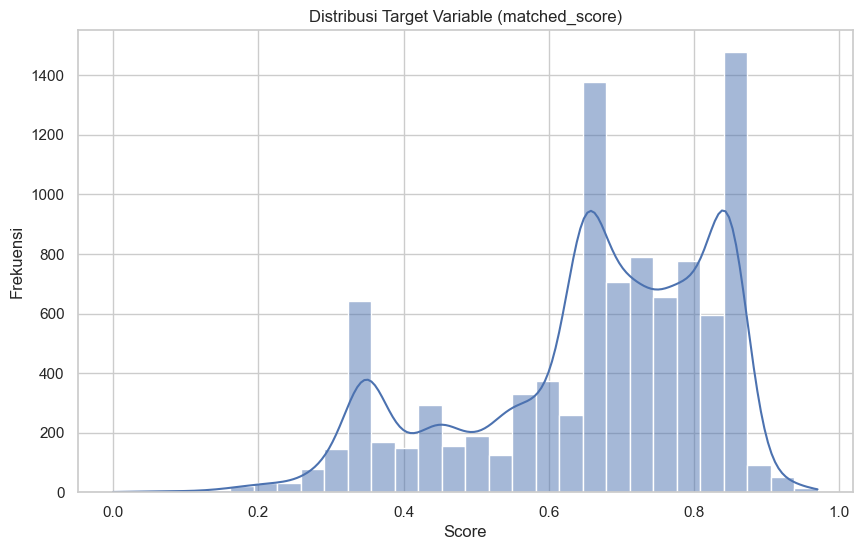

In [7]:
# Visualisasi distribusi target
plt.figure(figsize=(10, 6))
sns.histplot(df['matched_score'], bins=30, kde=True)
plt.title('Distribusi Target Variable (matched_score)')
plt.xlabel('Score')
plt.ylabel('Frekuensi')
plt.show()

Panjang Teks Statistik:

career_objective:
count    4740.000000
mean      225.649367
std       143.116171
min        26.000000
25%       144.000000
50%       210.000000
75%       268.000000
max      1425.000000
Name: career_objective, dtype: float64


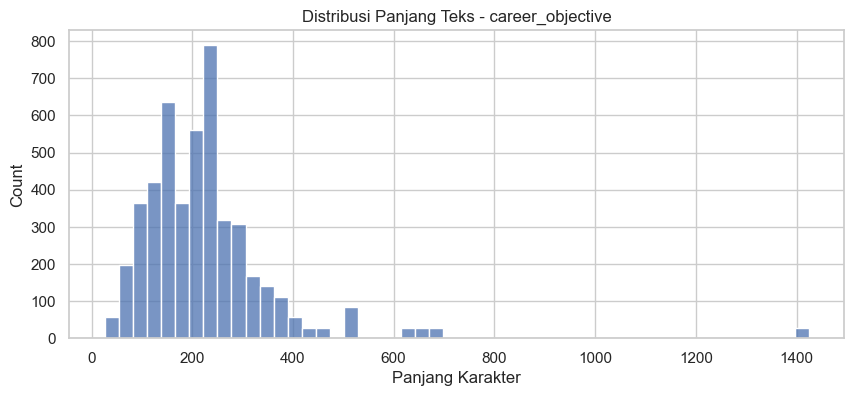


skills:
count    9488.000000
mean      371.750843
std       359.168635
min         2.000000
25%       161.000000
50%       243.000000
75%       504.000000
max      3104.000000
Name: skills, dtype: float64


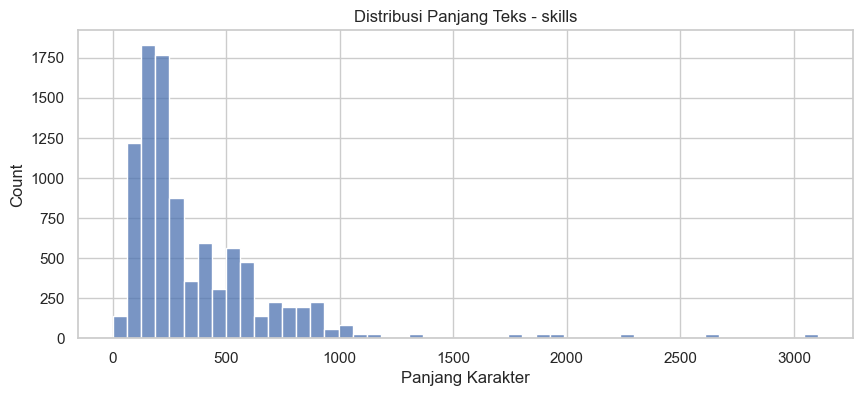


responsibilities:
count    9544.000000
mean      217.465319
std       101.041713
min        72.000000
25%       170.000000
50%       181.000000
75%       247.000000
max       587.000000
Name: responsibilities, dtype: float64


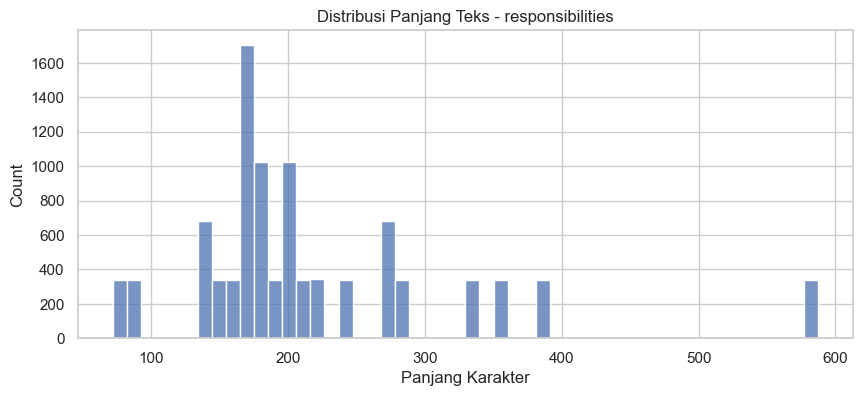


educationaL_requirements:
count    9544.000000
mean       51.838852
std        29.797557
min        15.000000
25%        25.000000
50%        52.000000
75%        75.000000
max       127.000000
Name: educationaL_requirements, dtype: float64


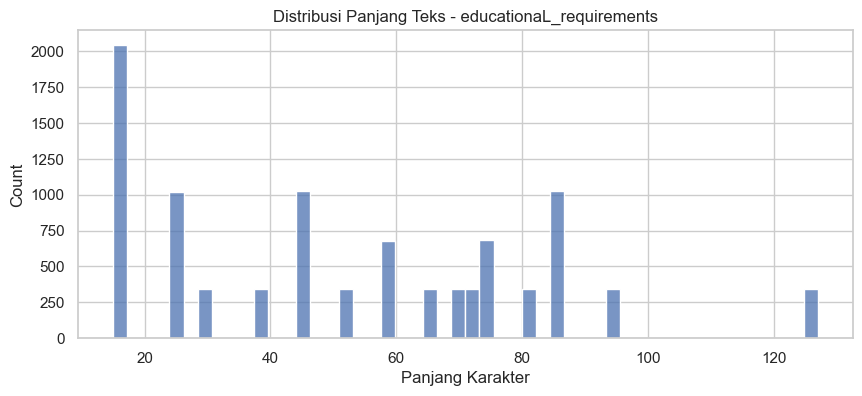

In [8]:
# Analisis kolom teks utama
text_cols = ['career_objective', 'skills', 'responsibilities', 'educationaL_requirements']

print("Panjang Teks Statistik:")
for col in text_cols:
    if col in df.columns:
        text_lengths = df[col].str.len()
        print(f"\n{col}:")
        print(text_lengths.describe())
        
        plt.figure(figsize=(10, 4))
        sns.histplot(text_lengths.dropna(), bins=50)
        plt.title(f'Distribusi Panjang Teks - {col}')
        plt.xlabel('Panjang Karakter')
        plt.show()



Unique Values in degree_names:
180


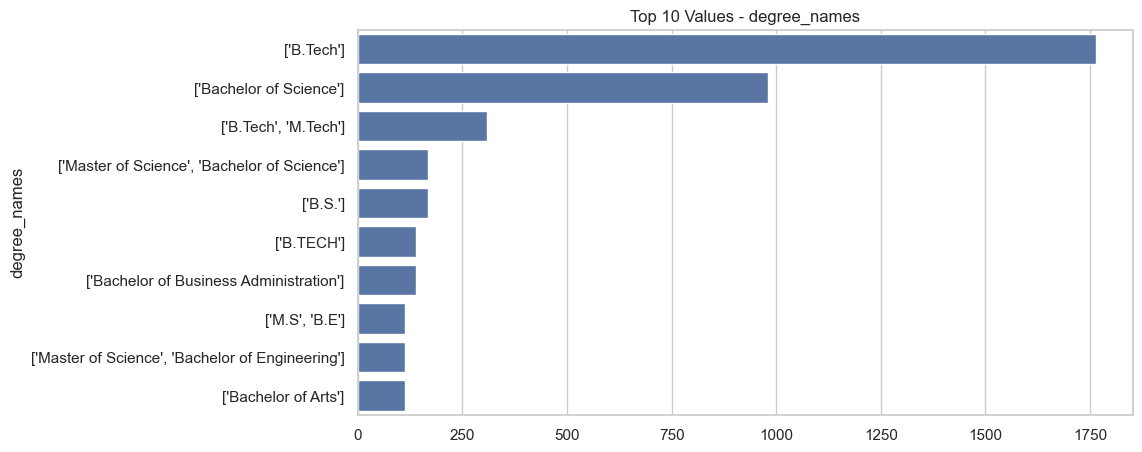


Unique Values in result_types:
30


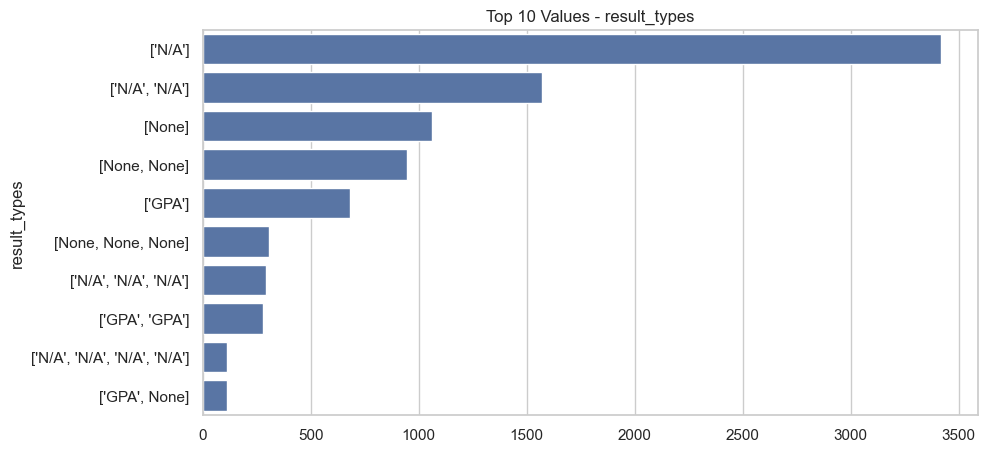


Unique Values in major_field_of_studies:
210


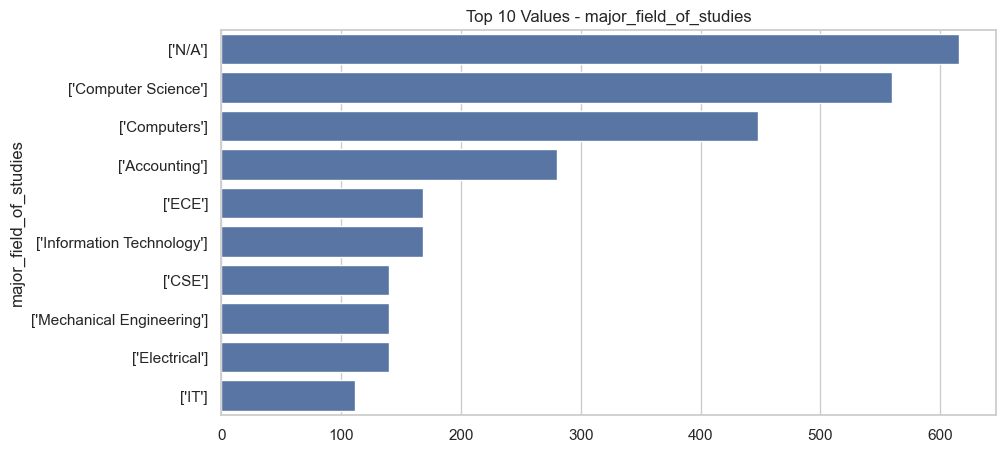


Unique Values in languages:
18


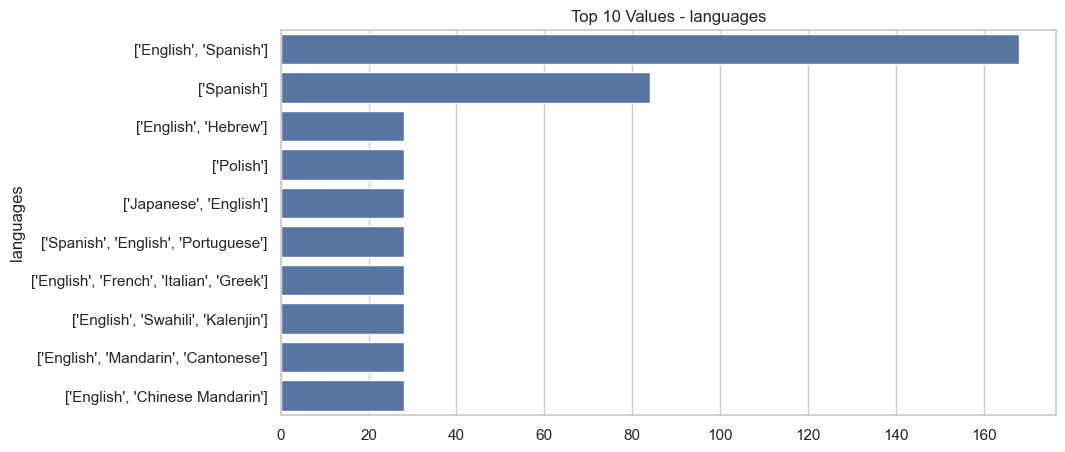

In [9]:
# Analisis fitur kategorikal
cat_cols = ['degree_names', 'result_types', 'major_field_of_studies', 'languages']

for col in cat_cols:
    if col in df.columns:
        print(f"\nUnique Values in {col}:")
        print(df[col].nunique())
        
        # Tampilkan top 10 values
        top_values = df[col].value_counts().head(10)
        plt.figure(figsize=(10, 5))
        sns.barplot(x=top_values.values, y=top_values.index)
        plt.title(f'Top 10 Values - {col}')
        plt.show()

# Preprocesing

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...


True

In [12]:
def clean_text(text):
    """Fungsi untuk membersihkan teks"""
    if pd.isna(text):
        return ""
    
    # Convert to string
    text = str(text)
    
    # Lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def preprocess_data(df):
    """Fungsi utama untuk preprocessing data"""
    # Handle missing values
    df['career_objective'] = df['career_objective'].fillna('')
    df['skills'] = df['skills'].fillna('')
    df['responsibilities'] = df['responsibilities'].fillna('')
    df['educationaL_requirements'] = df['educationaL_requirements'].fillna('')
    
    # Clean text columns
    text_cols = ['career_objective', 'skills', 'responsibilities', 
                 'educationaL_requirements', 'degree_names']
    
    for col in text_cols:
        df[col] = df[col].apply(clean_text)
    
    # Feature engineering - Experience years
    def calculate_experience(start_dates, end_dates):
        try:
            start = pd.to_datetime(start_dates)
            end = pd.to_datetime(end_dates)
            return (end - start).days / 365
        except:
            return 0
    
    df['experience_years'] = df.apply(
        lambda x: calculate_experience(x['start_dates'], x['end_dates']), 
        axis=1
    )
    
    # Feature engineering - Education level
    def get_education_level(degree):
        degree = str(degree).lower()
        if 'phd' in degree or 'doctor' in degree:
            return 3
        elif 'master' in degree or 'ms' in degree or 'mba' in degree:
            return 2
        elif 'bachelor' in degree or 'bs' in degree or 'ba' in degree:
            return 1
        else:
            return 0
    
    df['education_level'] = df['degree_names'].apply(get_education_level)
    
    # Feature engineering - Skills count
    df['skills_count'] = df['skills'].apply(lambda x: len(x.split(',')))
    
    # Create combined text feature
    df['combined_text'] = (
        "Career Objective: " + df['career_objective'] + 
        " Skills: " + df['skills'] + 
        " Education: " + df['degree_names'] + 
        " Experience: " + df['responsibilities']
    )
    
    return df

In [13]:
# Preprocess data
processed_df = preprocess_data(df.copy())

# Tampilkan hasil preprocessing
print("Setelah Preprocessing:")
processed_df[['experience_years', 'education_level', 'skills_count', 'combined_text']].head(3)

Setelah Preprocessing:


,experience_years,education_level,skills_count,combined_text
0,0.0,0,1,Career Objective: big data analytics working a...
1,0.0,2,1,Career Objective: fresher looking to join as a...
2,0.0,0,1,Career Objective: Skills: software developmen...


In [14]:
# Persiapkan fitur dan target
numerical_features = processed_df[['experience_years', 'education_level', 'skills_count']]
target = processed_df['matched_score']

In [15]:
# Normalisasi fitur numerik
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, 
    target, 
    test_size=0.2, 
    random_state=42
)

print(f"\nDimensi Data:")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Dimensi Data:
Train: (7635, 3), Test: (1909, 3)


# Pemodelan

In [16]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

c:\Users\ASUS\Downloads\MBKM DataIns\RAG CV\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# Konfigurasi model
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

c:\Users\ASUS\Downloads\MBKM DataIns\RAG CV\.venv\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [18]:
# Dataset Class
class ResumeDataset(Dataset):
    def __init__(self, texts, numerical_features, scores):
        self.texts = texts
        self.numerical = numerical_features
        self.scores = scores
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors="pt"
        )
        
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'numerical': torch.FloatTensor(self.numerical[idx]),
            'score': torch.FloatTensor([self.scores[idx]])
        }

In [19]:
# Model Architecture
class ResumeScoringModel(nn.Module):
    def __init__(self, n_numerical_features):
        super().__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.text_fc = nn.Linear(768, 64)
        self.num_fc = nn.Linear(n_numerical_features, 32)
        self.combined_fc = nn.Linear(64 + 32, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, input_ids, attention_mask, numerical):
        # Text features
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state.mean(dim=1)
        text_features = self.text_fc(pooled_output)
        
        # Numerical features
        num_features = self.num_fc(numerical)
        
        # Combine
        combined = torch.cat([text_features, num_features], dim=1)
        combined = self.dropout(combined)
        score = self.combined_fc(combined)
        
        return score

In [21]:
# Siapkan DataLoader
train_texts = processed_df.iloc[y_train.index, :]['combined_text'].values
test_texts = processed_df.iloc[y_test.index, :]['combined_text'].values

train_dataset = ResumeDataset(train_texts, X_train, y_train.values)
test_dataset = ResumeDataset(test_texts, X_test, y_test.values)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [22]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResumeScoringModel(n_numerical_features=X_train.shape[1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [23]:
# Training Loop
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numerical = batch['numerical'].to(device)
        scores = batch['score'].to(device)
        
        outputs = model(input_ids, attention_mask, numerical)
        loss = criterion(outputs, scores)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            numerical = batch['numerical'].to(device)
            scores = batch['score'].to(device)
            
            outputs = model(input_ids, attention_mask, numerical)
            loss = criterion(outputs, scores)
            
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [ ]:
# Jalankan Training
NUM_EPOCHS = 10
best_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/resume_scoring/best_model.pt")
        print("Model terbaik disimpan!")

In [ ]:
# Visualisasi Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualisasi

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def predict(model, dataloader):
    model.eval()
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            numerical = batch['numerical'].to(device)
            scores = batch['score'].to(device)
            
            outputs = model(input_ids, attention_mask, numerical)
            
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_true.extend(scores.cpu().numpy().flatten())
    
    return all_preds, all_true

In [ ]:
# Load model terbaik
model.load_state_dict(torch.load("../models/best_model.pt"))
predictions, true_values = predict(model, test_loader)

In [ ]:
# Hitung metrik
mae = mean_absolute_error(true_values, predictions)
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(true_values, predictions)

print("\nHasil Evaluasi:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

In [ ]:
# Visualisasi prediksi vs aktual
plt.figure(figsize=(10, 10))
plt.scatter(true_values, predictions, alpha=0.5)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Scores')
plt.show()

In [ ]:
# Analisis residual
residuals = np.array(true_values) - np.array(predictions)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

In [ ]:
import joblib
import os

# Buat direktori jika belum ada
os.makedirs("../models/resume_scoring", exist_ok=True)
os.makedirs("../models/preprocessing", exist_ok=True)

# Simpan model dan preprocessing artifacts
torch.save(model.state_dict(), "../models/resume_scoring/best_model.pt")
joblib.dump(scaler, "../models/preprocessing/scaler.joblib")
tokenizer.save_pretrained("../models/preprocessing/tokenizer")

In [ ]:
# Simpan config
model_config = {
    "model_name": MODEL_NAME,
    "numerical_features": ['experience_years', 'education_level', 'skills_count'],
    "input_length": 512,
    "target_range": [0, 100]
}

import json
with open("../models/resume_scoring/config.json", "w") as f:
    json.dump(model_config, f)

print("\nModel dan artifacts berhasil disimpan!")